# Developing an AI application

AI algorithms are being incorporated more and more into everyday applications. In this project, a deep learning model is trained to recognize and classify different species of flowers, then exported for use in an application. 


**Data sources**:

We will be using [a dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories provided by Udacity, as put together by the Department of Engineering Science, University of Oxford.

## Scoping 

- Load and preprocess the image dataset
- Label mapping
- Build and Train Image Classifier
- Test the network
- Use Trained Classifier for Inference

In [1]:
# !python -m pip install torch==2.0.0

In [2]:
#!python -m pip install torchvision

## Import Modules

In [3]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from collections import OrderedDict
from PIL import Image
import io
import pathlib

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [4]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)

# Should return True when GPU is enabled. 
print(torch.cuda.is_available()) 

2.0.1
True


## Load and Preprocess image dataset

- The dataset is split into three parts, training, validation, and testing. For the training, transformations such as random scaling, cropping, and flipping is applied. This will help the network generalize leading to better performance.  

- No scaling or rotation transformations are applied to validation and testing sets since they will be used to measure the model's performance on data it hasn't seen yet.

- All input data is resized to 224x224 pixels as required by the pre-trained networks.

- For all three sets, the means and standard deviations of the images are normalized to what the network expects. These values were calculated from the ImageNet images and will shift each color channel to be centered at 0 and range from -1 to 1.
    - **means:** `[0.485, 0.456, 0.406]`
    - **standard deviations**: `[0.229, 0.224, 0.225]`

In [5]:
#download image directory
# !wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
# !unlink flowers
# !mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

In [6]:
#Image data
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
#Image Normalizations
mean_norm = [0.485, 0.456, 0.406]
std_norm = [0.229, 0.224, 0.225]

In [8]:
#Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation((30)),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean_norm, std_norm)])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_norm, std_norm)])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean_norm, std_norm)])

#Load datasets with ImageFolder
train_set = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_set = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_set = datasets.ImageFolder(test_dir, transform=test_transforms)

#define dataloaders using the image datasets and the transforms
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

## Label mapping

Category labels are mapped to actual category names of the flowers by loading object `cat_to_name.json`

In [9]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

## Build and Train Image Classifier

In [10]:
# Automatically uses CUDA if it's enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 

cuda:0


In [11]:
#load a pretrained network: vgg16
model = models.vgg16(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 129MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
#freeze parameters
for param in model.parameters():
    param.requires_grad = False

#define a new feed-forward classifier using those vgg16 features
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu1', nn.ReLU()),
                                        ('drop1', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(4096, 1024)),
                                        ('relu2', nn.ReLU()),
                                        ('drop2', nn.Dropout(p=0.5)),
                                        ('fc3', nn.Linear(1024, 102)),
                                        ('output', nn.LogSoftmax(dim=1))
                                       ]))
#define model
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
#define criterion, learning_rate, optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = .0001)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
print('Training in progress...')

#define number of epochs, steps, print_every; initialize running_loss
epochs = 7
steps = 0
print_every = 30
running_loss = 0

#initialize train_losses, validation_losses
train_losses, validation_losses = [], []

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        #Validation loop
        if steps % print_every == 0:
            model.eval()
            
            validation_loss = 0
            accuracy = 0
            
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(device), labels.to(device)
                
                    logps = model(images)
                    loss = criterion(logps, labels)
                    validation_loss += loss.item()

                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            train_losses.append(running_loss/len(trainloader))
            validation_losses.append(validation_loss/len(validloader))
            
            #print train loss, validation, loss and accuracy
            print(f"Epoch: {epoch+1}/{epochs}.."
                  f"Training Loss: {running_loss/print_every:.3f}.."
                  f"Validation Loss: {validation_loss/len(validloader):.3f}..",
                  f"Accuracy: {accuracy/len(validloader):.3f}")
            
            running_loss = 0
            model.train()
            
print('Training completed!')

Training in progress...
Epoch: 1/7..Training Loss: 4.433..Validation Loss: 3.855.. Accuracy: 0.211
Epoch: 1/7..Training Loss: 3.771..Validation Loss: 2.907.. Accuracy: 0.376
Epoch: 1/7..Training Loss: 3.173..Validation Loss: 2.083.. Accuracy: 0.532
Epoch: 2/7..Training Loss: 2.623..Validation Loss: 1.699.. Accuracy: 0.598
Epoch: 2/7..Training Loss: 2.287..Validation Loss: 1.301.. Accuracy: 0.687
Epoch: 2/7..Training Loss: 2.003..Validation Loss: 1.121.. Accuracy: 0.733
Epoch: 3/7..Training Loss: 1.802..Validation Loss: 0.993.. Accuracy: 0.755
Epoch: 3/7..Training Loss: 1.644..Validation Loss: 0.831.. Accuracy: 0.799
Epoch: 3/7..Training Loss: 1.581..Validation Loss: 0.734.. Accuracy: 0.840
Epoch: 3/7..Training Loss: 1.468..Validation Loss: 0.653.. Accuracy: 0.841
Epoch: 4/7..Training Loss: 1.357..Validation Loss: 0.601.. Accuracy: 0.863
Epoch: 4/7..Training Loss: 1.221..Validation Loss: 0.579.. Accuracy: 0.857
Epoch: 4/7..Training Loss: 1.235..Validation Loss: 0.516.. Accuracy: 0.874
E

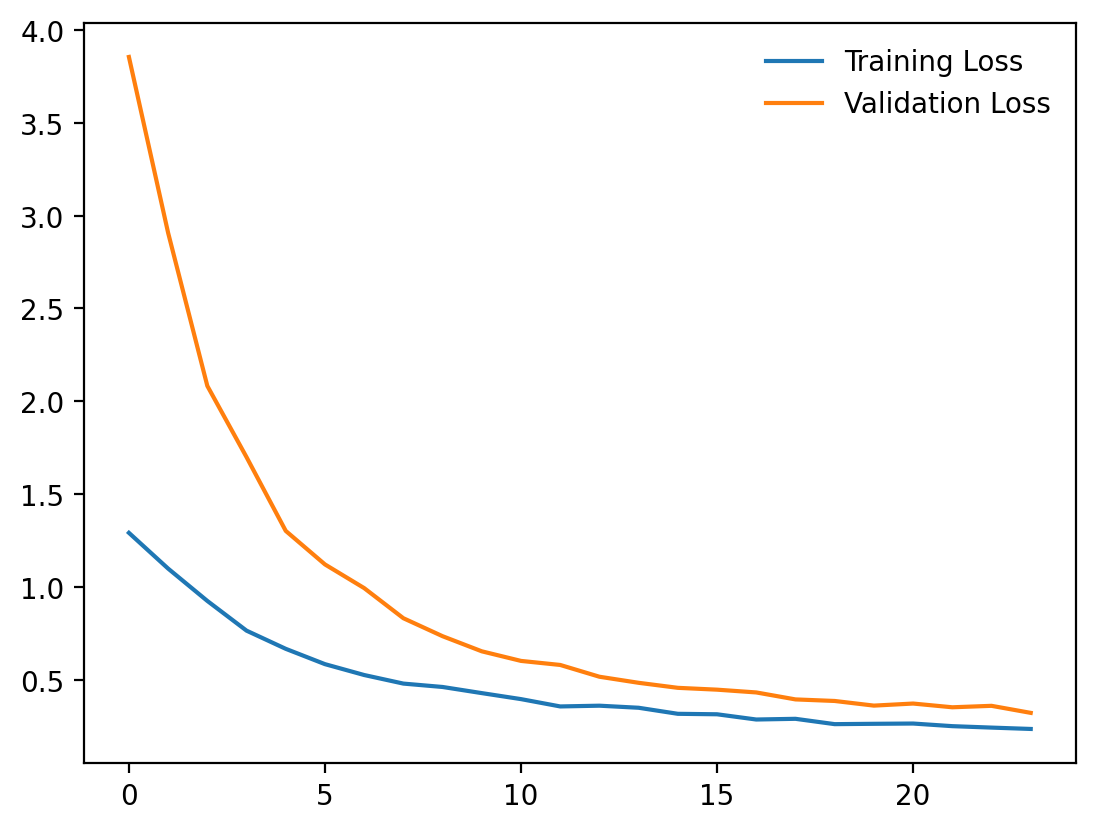

In [15]:
#visualize train and validation losses
plt.plot(train_losses, label = 'Training Loss')
plt.plot(validation_losses, label  = 'Validation Loss')
plt.legend(frameon=False);

## Test the network

Test the network on images the network has never seen, either in training or validation

In [16]:
#Do validation on the test set
test_correct = 0
test_total = 0

with torch.no_grad():
    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        _, predicted = torch.max(log_ps.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f'Total number of test images: {test_total}',
      f'Test Accuracy: {(test_correct/test_total)*100}%')

Total number of test images: 819 Test Accuracy: 88.88888888888889%


In [17]:
#print network's model.state_dict().keys()
print('Our model: \n\n', model, '\n')
print('The state dict keys: \n\n', model.state_dict().keys())

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

In [18]:
#Save network to a checkpoint 
model.class_to_idx = train_set.class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': 102,
              'epoch': epochs,
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx,
              'optimizer': optimizer.state_dict()
             }

torch.save(checkpoint, 'checkpoint.pth')

# Use Trained Classifier for Inference

- pass an image into the network and predict the class of the flower in the image

In [19]:
#first process a PIL image for inference
def process_image(image):
    img = Image.open(image)#.convert("RGB")
    load_img = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])
    
    image_tensor = load_img(img).float() 
    return image_tensor

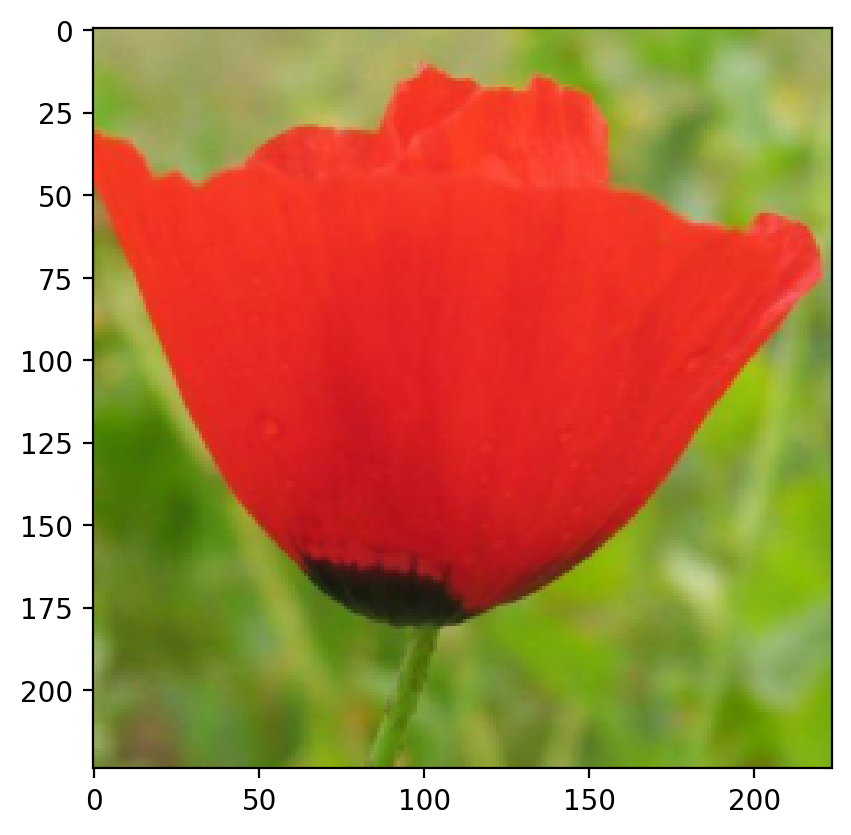

In [ ]:
#imshow for tensor
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

plt.show(imshow(process_image('flowers/test/26/image_06526.jpg'),None,None))

In [21]:
#predict class from image
def predict(image_path, model, topk=5):
    model.eval()
    
    model.to(device) 
    
    image = process_image(image_path)
    
    image.unsqueeze_(0) 
    image_tensor = image.to(device) 
    
    with torch.no_grad():
        log_ps = model(image_tensor)
                
        ps = torch.exp(log_ps)
        probs, labels = ps.topk(5, dim=1)

    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    probs = probs.cpu().numpy()[0]
    
    classes = []
    for label in labels.cpu().numpy()[0]:
        classes.append(idx_to_class[label]) 
    
    names = [cat_to_name[img_class] for img_class in classes]
    
    print(probs)
    print(classes)
    print(names)
    return probs, classes, names

[0.59106535 0.36466852 0.01440397 0.0143578  0.00880296]
['26', '74', '80', '16', '65']
['corn poppy', 'rose', 'anthurium', 'globe-flower', 'californian poppy']


Text(0.5, 0, 'Probabilities')

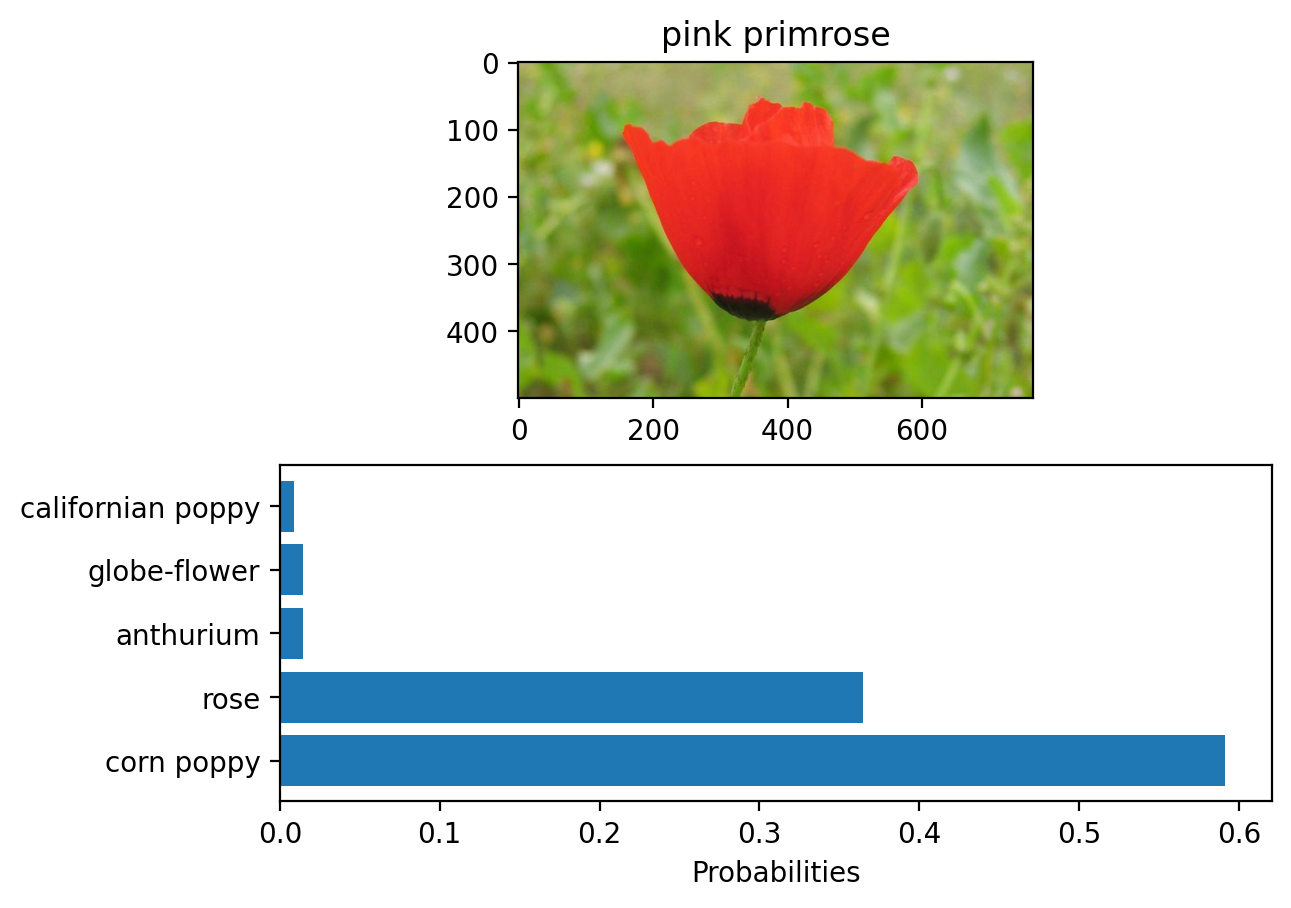

In [23]:
#Display the image along with the top 5 classes
image = 'flowers/test/26/image_06526.jpg'
check_image = Image.open(image)
img_name = cat_to_name['1']

probs, classes, names = predict(image, model)

names = [cat_to_name[img_class] for img_class in classes]

plt.subplot(2, 1, 1)
plt.title(img_name)
plt.imshow(check_image)

plt.subplot(2, 1, 2)
plt.barh(names, probs)
plt.xlabel('Probabilities')

In [24]:
#sanity check
print(cat_to_name['26'])

corn poppy
